In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
%matplotlib inline

from ast import literal_eval
from collections import Counter
from pandas.io.json import json_normalize

from sklearn.model_selection import train_test_split

In [2]:
from lightgbm import LGBMRegressor

In [3]:
import shap

# load JS visualization code to notebook
shap.initjs()

# Load data

In [4]:
# user = pd.read_json('../data/yelp_academic_dataset_user.json', lines=True)
# review = pd.read_json('../data/yelp_academic_dataset_review.json', lines=True)
business = pd.read_json('../data/yelp_academic_dataset_business.json', lines=True)
# checkin = pd.read_json('../data/yelp_academic_dataset_checkin.json', lines=True)
# tip = pd.read_json('../data/yelp_academic_dataset_tip.json', lines=True)


In [5]:
photo = pd.read_json('../data/yelp_academic_dataset_photo.json', lines=True)

# some graphs

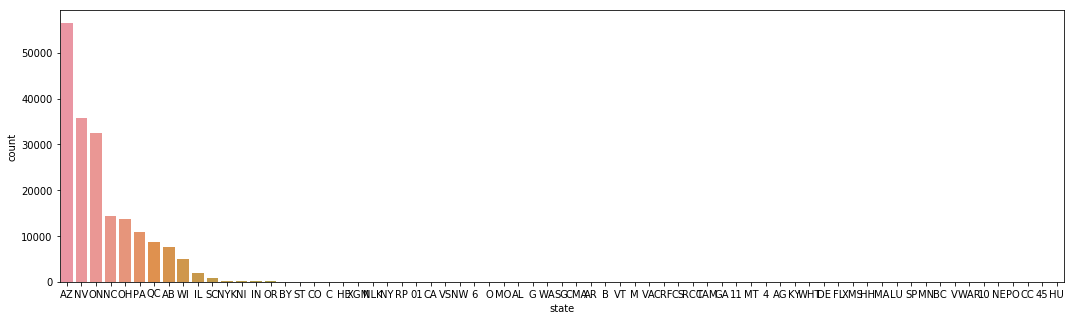

In [55]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,5)

sns.countplot(x='state', order=business['state'].value_counts().index, data=business, ax=ax)

In [34]:
business.groupby(['state'])['stars', 'review_count'].agg(['mean']).sort_values(
    by=[('stars', 'mean')], ascending=False)

,stars,review_count
,mean,mean
state,,
XMS,5.000000,3.000000
4,5.000000,3.000000
GA,5.000000,3.000000
AR,5.000000,9.500000
PO,5.000000,5.000000
RCC,5.000000,8.000000
KY,5.000000,3.000000
G,4.750000,8.000000


# business dataset

In [8]:
business = business[business['categories'].notnull() & business['hours'].notnull() & business['attributes'].notnull()]

In [9]:
business_food = business[business['categories'].str.contains('Restaurants')]

In [10]:
def attribute_parse(x):

    if pd.isnull(x):
        return x
    else:
        return literal_eval(x)


def expandfield(df, col, prefix='', coltype='dict', method='dumb'):
    """e.g.
        business_food_expand = expandfield(business_food, 'categories','cat_',coltype = 'list')
        business_food_expand = expandfield(business_food_expand, 'attributes','attr_')
        business_food_expand = expandfield(business_food_expand, 'hours','hr_')
        business_food_expand = expandfield(business_food_expand, 'hours', coltype='range') #split from and to
    """
    if col not in df.columns:
        print(col + " is not found. skipped.")
        return df
    
    if coltype == 'dict':
        try:
            temp = df[col].map(
                lambda x: literal_eval(x) if pd.notnull(x) else x).apply(
                    pd.Series)
        except ValueError:
            temp = df[col].apply(pd.Series)

        try:  # sometimes colname as 0 is produced
            del temp[0]
        except:
            print('')

    elif coltype == 'list':
        temp = df[col].str.split(',').map(lambda row: [x.strip() for x in row]
                                          ).str.join('|').str.get_dummies()

    elif coltype == 'range':  # for open - close time
        temp = df[col].str.split('-', expand=True)
        temp.columns = [col + '_open', col + '_close']

    else:
        raise (ValueError('coltype: dict|,|-'))
    temp.columns = [prefix + x for x in temp.columns]

    df = pd.concat([df, temp], ignore_index=False, axis=1)
    del df[col]
    return df

In [72]:
business_food_expand = expandfield(business_food, 'attributes','attr_')
business_food_expand = expandfield(business_food_expand, 'hours','hr_')

In [73]:
business_food_expand = expandfield(business_food_expand, 'categories','cat_',coltype = 'list')

In [74]:
# separate time from and to
for col in business_food_expand.columns:
    if col.startswith('hr_'):
        business_food_expand = expandfield(
            business_food_expand, col, coltype='range')

In [75]:
# further expand attributes
for atb, prefix in [('attr_Ambience', 'AMB_'), ('attr_BusinessParking', 'BP_'),
                    ('attr_GoodForMeal', 'GFM_'), ('attr_BestNights', 'BN_'),('attr_Music', 'MU_')]:
    business_food_expand = expandfield(business_food_expand, atb, prefix)

In [76]:
business_food_expand.shape

(42730, 766)

In [77]:
business_food_expand = pd.concat([business_food_expand,pd.get_dummies(business_food_expand['city'], prefix='city')],axis=1)
business_food_expand.drop(['city'],axis=1, inplace=True)

In [78]:
business_food_expand = pd.concat([business_food_expand,pd.get_dummies(business_food_expand['neighborhood'], prefix='neighborhood')],axis=1)
business_food_expand.drop(['neighborhood'],axis=1, inplace=True)

In [79]:
business_food_expand = pd.concat([business_food_expand,pd.get_dummies(business_food_expand['state'], prefix='state')],axis=1)
business_food_expand.drop(['state'],axis=1, inplace=True)

In [80]:
business_food_expand.drop(['cat_Food'],axis=1, inplace=True)

In [30]:
# business_food_expand.to_csv('../data/food_expand.csv')

# merge photo number

In [81]:
photo_num = photo.groupby(['business_id']).size().reset_index()

In [82]:
photo_num.columns = ['business_id', 'photo_num']

In [83]:
business_food_with_photo = pd.merge(business_food_expand, photo_num, on = ['business_id'], how='left')
business_food_with_photo['photo_num'] = business_food_with_photo['photo_num'].fillna(0)

In [84]:
business_food_with_photo.head()

,address,business_id,is_open,latitude,longitude,name,postal_code,review_count,stars,attr_BikeParking,...,state_QC,state_RCC,state_RP,state_SC,state_ST,state_VS,state_WI,state_XGM,state_XMS,photo_num
0,1314 44 Avenue NE,Apn5Q_b6Nz61Tq4XzPdf9A,1,51.091813,-114.031675,Minhas Micro Brewery,T2E 6L6,24,4.0,False,...,0,0,0,0,0,0,0,0,0,0.0
1,,AjEbIBw6ZFfln7ePHha9PA,0,35.960734,-114.939821,CK'S BBQ & Catering,89002,3,4.5,False,...,0,0,0,0,0,0,0,0,0,1.0
2,1335 rue Beaubien E,O8S5hYJ1SMc8fA4QBtVujA,0,45.540503,-73.599300,La Bastringue,H2G 1K7,5,4.0,True,...,1,0,0,0,0,0,0,0,0,0.0
3,1440 N. Dysart Ave,8-NRKkPY1UiFXW20WXKiXg,1,33.448106,-112.341302,Filiberto's Mexican Food,85323,40,2.5,True,...,0,0,0,0,0,0,0,0,0,43.0
4,4568 Highway 7 E,KapTdGyGs7RK0c68Z6hhhg,0,43.862484,-79.306960,Sushi 8,L3R 1M5,12,1.5,NaN,...,0,0,0,0,0,0,0,0,0,0.0


# Model Fitting

In [85]:
X = business_food_with_photo.drop([
    'address', 'business_id', 'latitude', 'longitude', 'name', 'postal_code', 'review_count',
    'stars'
],
                              axis=1,
                              inplace=False)
y = business_food_with_photo['stars']

In [86]:
## to be modified later
for col in X.columns:
    if col.startswith('attr_') or col.startswith('AMB_') or col.startswith(
            'BP_') or col.startswith('GFM_') or col.startswith('BN_') or col.startswith('MU_'):
        X[col] = X[col].astype(bool)

In [87]:
for col in X.columns:
    if col.startswith('hr_'):
        X.drop(col, axis=1, inplace=True)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [89]:
clf = LGBMRegressor(n_jobs=-1, n_estimators=500)
clf.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [90]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

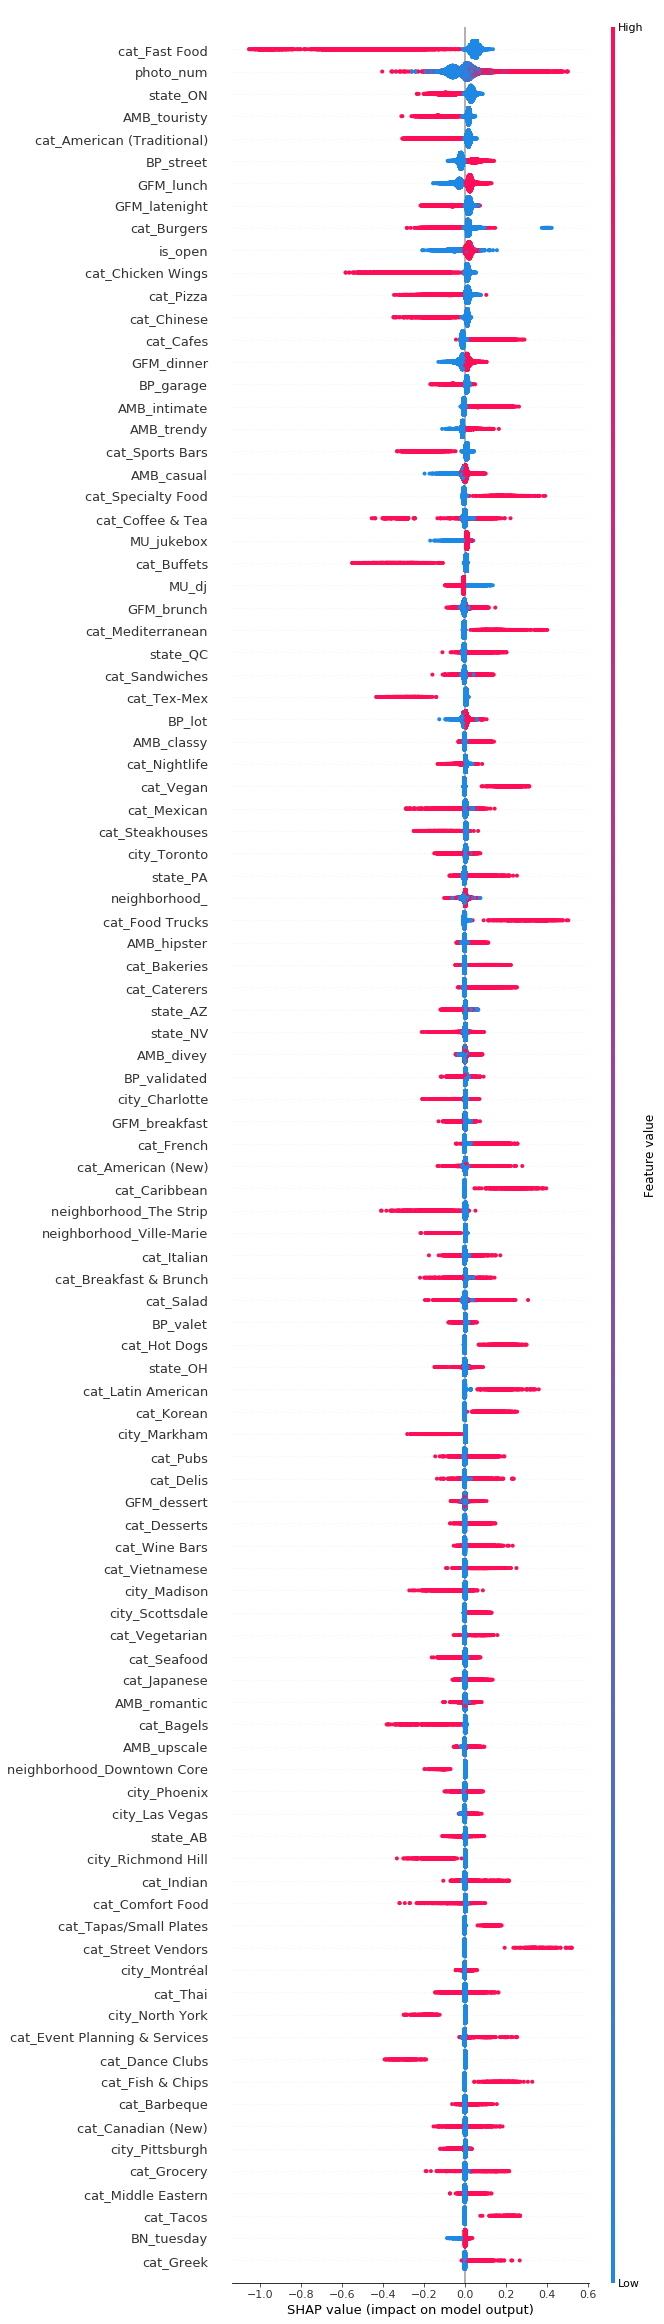

In [95]:
shap.summary_plot(shap_values, X_train, max_display=100)

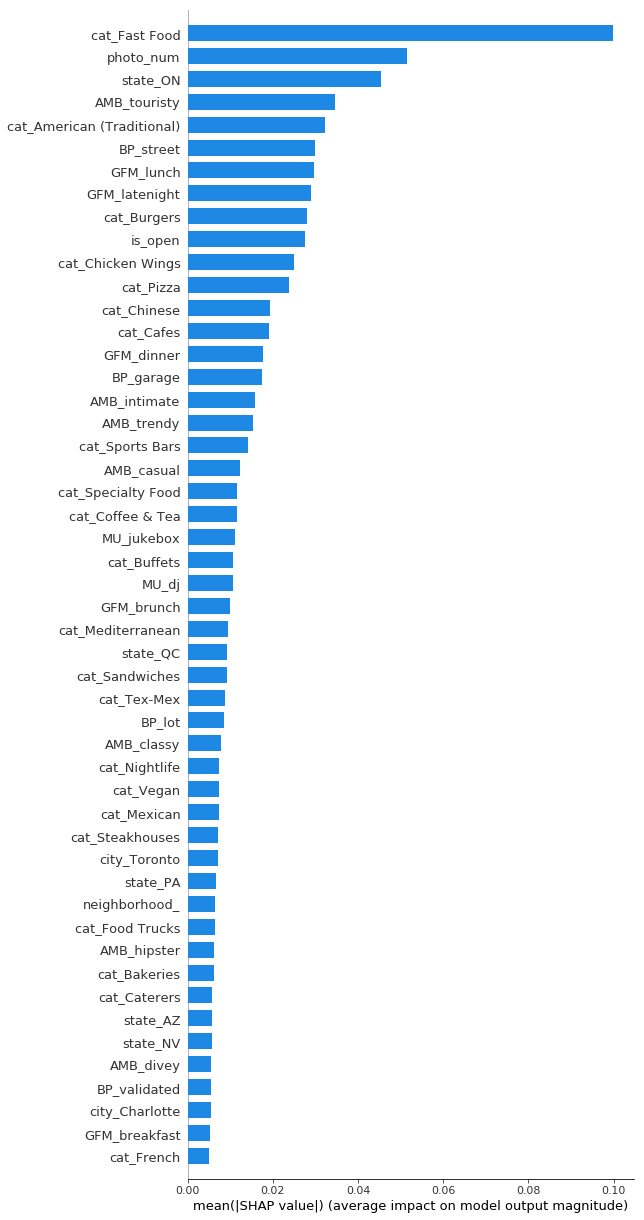

In [92]:
shap.summary_plot(shap_values, X, plot_type="bar", max_display=50 )

In [93]:
a = business.groupby(['city']).filter(lambda x: len(x) > 100)

In [94]:
a.groupby(['city'])['stars'].agg(['mean','size']).sort_values(by=['mean'], ascending=False)

,mean,size
city,,
Cave Creek,4.136364,264
Boulder City,4.093583,187
Scottsdale,4.069729,6346
Chagrin Falls,4.003906,128
Waxhaw,3.986957,115
Fountain Hills,3.983173,208
Lakewood,3.957105,373
Gilbert,3.955087,2516
Henderson,3.913056,3347


# Insights

* Do not do fast food or Chinese
* Cafe seems to be popular
* large number of photos leads to polarity
* Some attributes turn out to be important